In [1]:
using Revise
using ObjectiveEmpiricalBayes
import ObjectiveEmpiricalBayes: OptConfig, Transformation, FEModel, generatedata, transformmodel, 
    ReferenceRegularizer, ThikonovRegularizer, cvscore, ebprior, compareplot, likelihoodmat

using Random: seed!
using Distributions
using PyPlot
using CSV
using LinearAlgebra
linspace(x...) = LinRange(x...) |> collect

OPTCONFIG=OptConfig(XTOLABS=1e-8, DEBUG=true);

In [2]:
table = CSV.read("baseballdata.csv")

,FirstName,LastName,At-Bats,Hits,BattingAverage,RemainingAt-Bats,RemainingHits
,String,String,Int64,Int64,Float64,Int64,Int64
1,Roberto,Clemente,45,18,0.4,367,127
2,Frank,Robinson,45,17,0.378,426,127
3,Frank,Howard,45,16,0.356,521,144
4,Jay,Johnstone,45,15,0.333,275,61
5,Ken,Berry,45,14,0.311,418,114
6,Jim,Spencer,45,14,0.311,466,126
7,Don,Kessinger,45,13,0.289,586,155
8,Luis,Alvarado,45,12,0.267,138,29
9,Ron,Santo,45,11,0.244,510,137


In [3]:
xs = linspace(0.1,.5,300+2)[2:end-1] # account for midpoint rule

data = table[:,:BattingAverage]
M = length(data)
N = 45
σ = sqrt(mean(data) * (1 - mean(data)) / N)

0.06582090626055082

In [4]:
# cross validation routine
function cverp(m, data; ncv=10, rs = linspace(0.01,0.1,ncv))
    regs = [ReferenceRegularizer(m, r) for r in rs]
    @time ss = [cvscore(m, data, dd->ebprior(m, dd, r, OPTCONFIG)) for r in regs]
    @show reg = rs[argmax(ss)]
    plot(rs, ss)
    ebprior(m,  data, ReferenceRegularizer(m,  reg), OPTCONFIG), reg
end

cverp (generic function with 1 method)

In [5]:
B = 1 - (M - 3) * σ^2 / sum((data .- mean(data)).^2)
μ_js = mean(data)
σ_js = sqrt(B * σ^2 / (1 - B))

w_js = normalize(pdf.(Normal(μ_js, σ_js), xs), 1);

  8.412260 seconds (9.23 M allocations: 49.730 GiB, 9.21% gc time)
reg = rs[argmax(ss)] = 

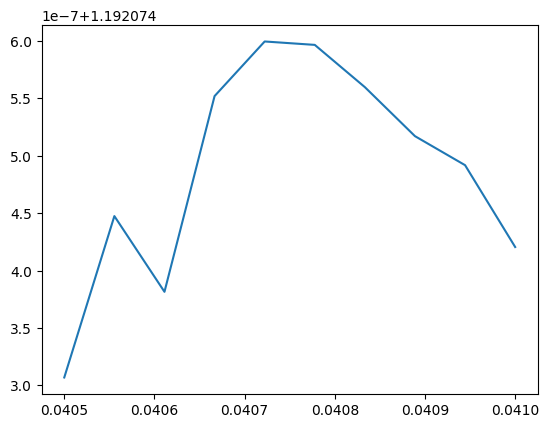

0.04072222222222223


([3.5744869172980537e-10, 4.344516280610917e-10, 5.294166493631947e-10, 6.467854128575186e-10, 7.921483981538235e-10, 9.725410420436561e-10, 1.196854843531156e-9, 1.4763123758417125e-9, 1.8251096954671537e-9, 2.2612235554837687e-9  …  3.1768293687010916e-11, 2.718731066337237e-11, 2.3337666804881345e-11, 2.0095116116715147e-11, 1.7353526450752268e-11, 1.5034922427642363e-11, 1.3063749749647063e-11, 1.1392024044140736e-11, 9.96097164457083e-12, 8.729068767224613e-12], 0.04072222222222223)

In [6]:
m = FEModel(f=x->x, xs=xs, σ=σ)

w_er, reg = cverp(m, data, rs = linspace(0.0405,0.041,10))

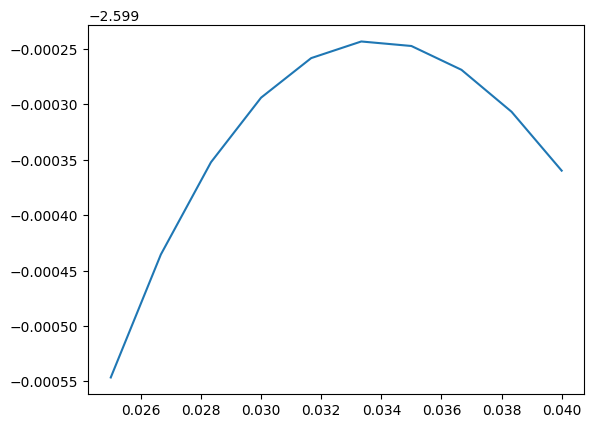

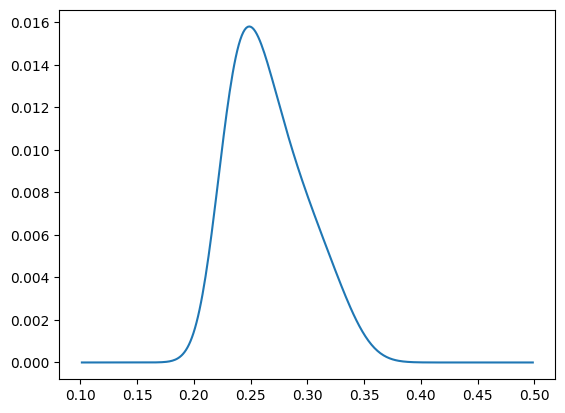

  7.662789 seconds (3.19 M allocations: 52.245 GiB, 23.06% gc time)
reg = rs[argmax(ss)] = 0.03333333333333333


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f6a946695d0>

In [12]:
# TODO: Binomial Model

m_bin = ObjectiveEmpiricalBayes.BinomialModel(N, xs)
reg_bin = 0

data_bin = round.(Int, data * N)
w_bin, reg = cverp(m_bin, data_bin, rs = linspace(0.025,0.04,10))

figure()
plot(xs, w_bin)

In [8]:
function posteriors(w)
    L=likelihoodmat(m, data)
    post = w .* L'
    post = post ./ sum(post, dims=1)
end

posteriormeans(w) = posteriors(w)' * xs

truth = table[:, :RemainingHits] ./ table[:, Symbol("RemainingAt-Bats")]

function errors(w)
    posteriormeans(w) - truth
end

mse(w) = mean(x->x^2, errors(w))

mse (generic function with 1 method)

In [9]:
# compute the individual posteriors
posts = hcat((posteriormeans(w) for w in [w_js, w_er, w_bin])...)

18×3 Array{Float64,2}:
 0.293979  0.303475  0.298279
 0.289306  0.296413  0.292434
 0.284634  0.28936   0.286573
 0.279749  0.28217   0.280531
 0.275076  0.275612  0.274927
 0.275076  0.275612  0.274927
 0.270404  0.269464  0.269568
 0.265731  0.263779  0.264508
 0.260846  0.258345  0.259569
 0.260846  0.258345  0.259569
 0.256174  0.253613  0.255189
 0.256174  0.253613  0.255189
 0.256174  0.253613  0.255189
 0.256174  0.253613  0.255189
 0.256174  0.253613  0.255189
 0.251501  0.249297  0.25114 
 0.246828  0.245349  0.247401
 0.242156  0.241718  0.243946

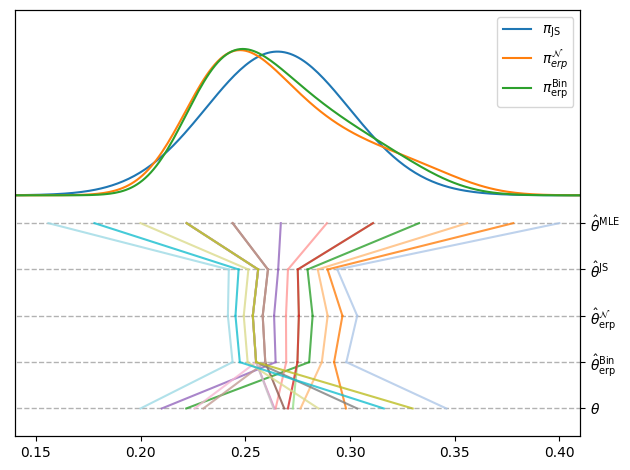

In [49]:
fig, ax1 = subplots()

xmin, xmax = .14, .41
ymin, ymax = -0.026, 0.02

plot(xs, w_js, label="\$\\pi_{\\rm JS}\$")
plot(xs, w_er, label="\$\\pi^{\\mathcal{N}}_{erp}\$")
plot(xs, w_bin, label="\$\\pi^{\\rmBin}_{\\rmerp}\$")
legend()

#grid(which="major",axis="both", alpha=0.2)

xlim(xmin, xmax)
ylim(ymin, ymax)
ax1.set_yticks([])

#subplot(212, sharex=ax1)
offset = -0.003
scale=-5e-3

dots = hcat(data, posts, truth)
scale = scale=-5e-3

yt = vcat([0,1,2,3,4] .* scale.+offset)
ytl = vcat(["\$\\hat\\theta^{\\rmMLE}\$",
        "\$\\hat\\theta^{\\rmJS}\$", 
        "\$\\hat\\theta_{\\rmerp}^{\\mathcal{N}}\$", 
        "\$\\hat\\theta_{\\rmerp}^{\\rmBin}\$", 
        "\$\\theta\$"])

ax2 = ax1.twinx()
#ax2.yaxis.set_label_position("right")


ax2.set_ylim(ymin , ymax)
ax2.set_yticks(yt)
ax2.set_yticklabels(ytl)

ax2.hlines([0,1,2,3,4] .* scale.+offset, 0, 1, linewidth=1, alpha=0.3, linestyle="dashed")

for i=1:size(dots, 1)
    for j=1:size(dots, 2)-1
        ax2.plot([dots[i,j], dots[i,j+1]], [j-1,j].*scale.+offset, alpha=0.8, c=PyPlot.cm.tab20(i/18))
    end
end
fig.tight_layout()

In [50]:
# compute mean squared errors
mse_ml = mean(x->x^2, data - truth)
@show mse_ml
@show mse(w_js) / mse_ml
@show mse(w_er) / mse_ml
@show mse(w_bin) / mse_ml

mse_ml = 0.004764985095190408
mse(w_js) / mse_ml = 0.3124225614986754
mse(w_er) / mse_ml = 0.3123380131757944
mse(w_bin) / mse_ml = 0.3096651876629368


0.3096651876629368